Reading & Splitting Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

run_df = pd.read_csv("Data/run_df.csv")
pass_df = pd.read_csv("Data/pass_df.csv")

teams_features = [
    'posteam_ATL', 'posteam_BAL', 'posteam_BUF', 'posteam_CAR', 'posteam_CHI', 'posteam_CIN', 'posteam_CLE', 'posteam_DAL', 'posteam_DEN', 'posteam_DET', 'posteam_GB', 
    'posteam_HOU', 'posteam_IND', 'posteam_JAX', 'posteam_KC', 'posteam_LA', 'posteam_LAC', 'posteam_LV', 'posteam_MIA', 'posteam_MIN', 'posteam_NE', 'posteam_NO', 
    'posteam_NYG', 'posteam_NYJ', 'posteam_PHI', 'posteam_PIT', 'posteam_SEA', 'posteam_SF', 'posteam_TB', 'posteam_TEN', 'posteam_WAS', 'posteam_type_home',
    'defteam_ATL', 'defteam_BAL', 'defteam_BUF', 'defteam_CAR', 'defteam_CHI', 'defteam_CIN', 'defteam_CLE', 'defteam_DAL', 'defteam_DEN', 'defteam_DET', 'defteam_GB', 
    'defteam_HOU', 'defteam_IND', 'defteam_JAX', 'defteam_KC', 'defteam_LA', 'defteam_LAC', 'defteam_LV', 'defteam_MIA', 'defteam_MIN', 'defteam_NE', 'defteam_NO', 
    'defteam_NYG', 'defteam_NYJ', 'defteam_PHI', 'defteam_PIT', 'defteam_SEA', 'defteam_SF', 'defteam_TB', 'defteam_TEN', 'defteam_WAS'
    ]

# drop teams feature
run_df = run_df.drop(teams_features, axis=1)
pass_df = pass_df.drop(teams_features, axis=1)

# set fraction between 0 and 1 (e.g. 0.05 -> 5% df)
fraction = 0.1

run_df_sampled = run_df.sample(frac=fraction, random_state=42)
pass_df_sampled = pass_df.sample(frac=fraction, random_state=42)

# Reset the index if needed
run_df_sampled = run_df_sampled.reset_index(drop=True)
pass_df_sampled = pass_df_sampled.reset_index(drop=True)

run_features = run_df_sampled.drop('yards_gained', axis=1)
run_target = run_df_sampled['yards_gained']

pass_features = pass_df_sampled.drop('yards_gained', axis=1)
pass_target = pass_df_sampled['yards_gained']

# Split the data into training and testing sets for runs and passes
run_X_train, run_X_test, run_y_train, run_y_test = train_test_split(run_features, run_target, test_size=0.2, random_state=42)
pass_X_train, pass_X_test, pass_y_train, pass_y_test = train_test_split(pass_features, pass_target, test_size=0.2, random_state=42)




Linear Regression

Run Model Mean Squared Error: 10.982499233975215
Pass Model Mean Squared Error: 17.051328086962986
Run Model Mean Absolute Error: 2.3766198384713295
Pass Model Mean Absolute Error: 3.1605498420396927
Run Model Root Mean Squared Error: 3.313985400386552
Pass Model Root Mean Squared Error: 4.12932537915856


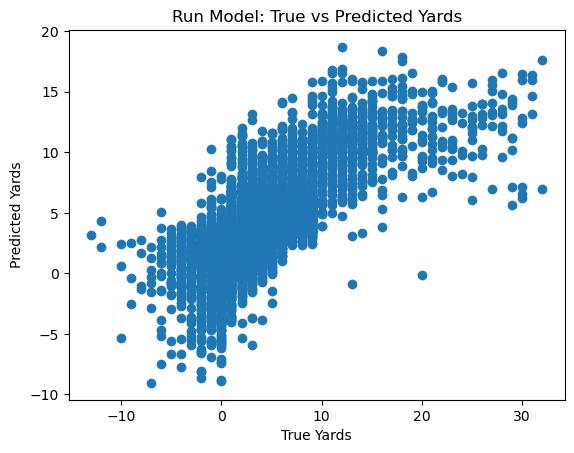

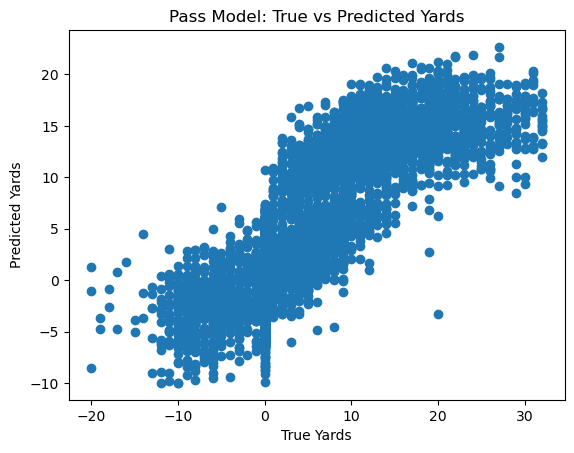

Run Model Cross-Validation Mean Squared Error: 10.87306682699408
Pass Model Cross-Validation Mean Squared Error: 16.866016279247233


In [18]:
run_model = LinearRegression()
run_model.fit(run_X_train, run_y_train)

pass_model = LinearRegression()
pass_model.fit(pass_X_train, pass_y_train)

# Make predictions on the test set
run_predictions = run_model.predict(run_X_test)
pass_predictions = pass_model.predict(pass_X_test)

# Evaluate the models
run_mse = mean_squared_error(run_y_test, run_predictions)
pass_mse = mean_squared_error(pass_y_test, pass_predictions)

run_rmse = mean_squared_error(run_y_test, run_predictions, squared = False)
pass_rmse = mean_squared_error(pass_y_test, pass_predictions, squared = False)

run_msa = mean_absolute_error(run_y_test, run_predictions)
pass_msa = mean_absolute_error(pass_y_test, pass_predictions)

print(f"Run Model Mean Squared Error: {run_mse}")
print(f"Pass Model Mean Squared Error: {pass_mse}")
print(f"Run Model Mean Absolute Error: {run_msa}")
print(f"Pass Model Mean Absolute Error: {pass_msa}")
print(f"Run Model Root Mean Squared Error: {run_rmse}")
print(f"Pass Model Root Mean Squared Error: {pass_rmse}")


# Visualize predictions for runs
plt.scatter(run_y_test, run_predictions)
plt.title('Run Model: True vs Predicted Yards')
plt.xlabel('True Yards')
plt.ylabel('Predicted Yards')
plt.show()

# Visualize predictions for passes
plt.scatter(pass_y_test, pass_predictions)
plt.title('Pass Model: True vs Predicted Yards')
plt.xlabel('True Yards')
plt.ylabel('Predicted Yards')
plt.show()

# Cross-validation for runs
run_cv_scores = cross_val_score(run_model, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")

# Cross-validation for passes
pass_cv_scores = cross_val_score(pass_model, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Polynomial Regression

Run Model Mean Squared Error: 8.080809145805867
Pass Model Mean Squared Error: 13.235212622132206


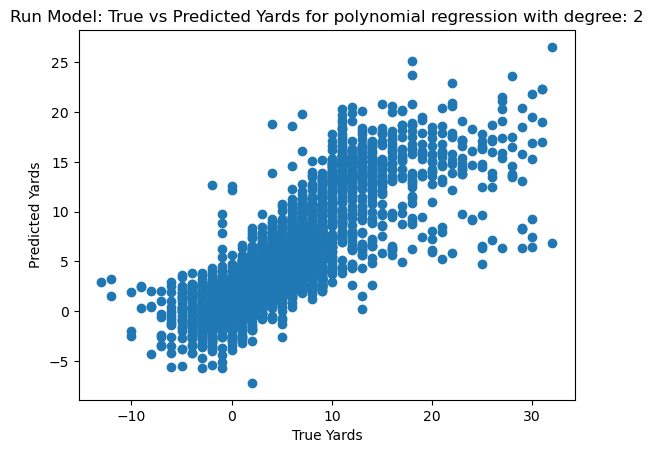

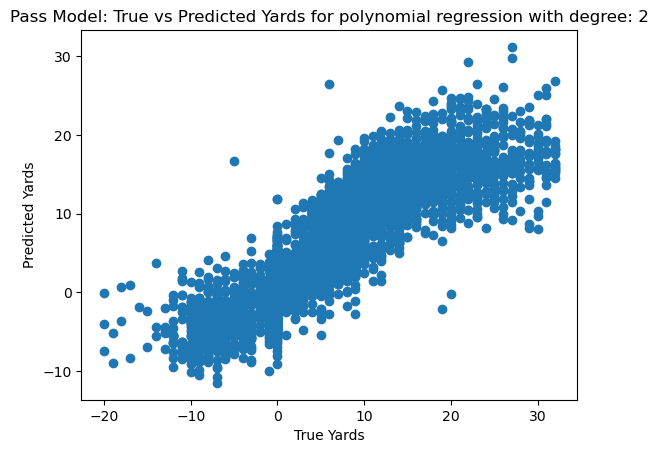

Run Model Mean Squared Error: 10.65215395413444
Pass Model Mean Squared Error: 18.66151120075441


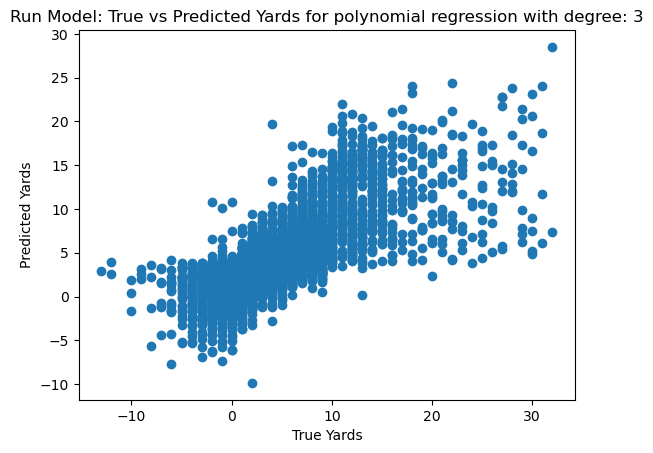

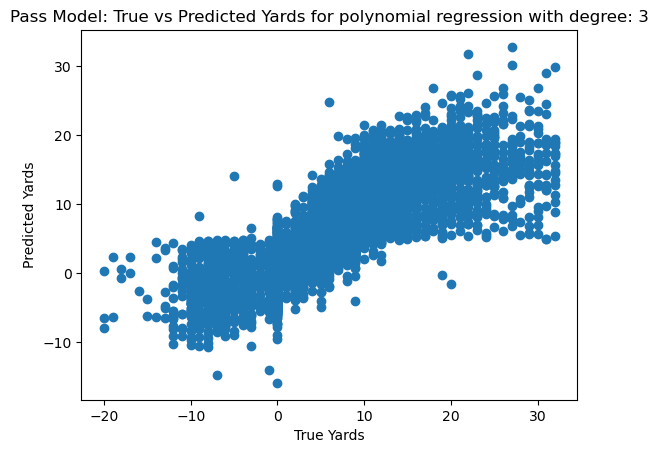

In [2]:
for degree in [2, 3, 4, 5]:
    run_poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    run_poly_model.fit(run_X_train, run_y_train)
    run_predictions = run_poly_model.predict(run_X_test)

    pass_poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    pass_poly_model.fit(pass_X_train, pass_y_train)
    pass_predictions = pass_poly_model.predict(pass_X_test)

    # Evaluate the models
    run_mse = mean_squared_error(run_y_test, run_predictions)
    pass_mse = mean_squared_error(pass_y_test, pass_predictions)

    print(f"Run Model Mean Squared Error: {run_mse}")
    print(f"Pass Model Mean Squared Error: {pass_mse}")

    # Visualize predictions for runs
    plt.scatter(run_y_test, run_predictions)
    plt.title('Run Model: True vs Predicted Yards for polynomial regression with degree: ' + str(degree))
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

    # Visualize predictions for passes
    plt.scatter(pass_y_test, pass_predictions)
    plt.title('Pass Model: True vs Predicted Yards for polynomial regression with degree: ' + str(degree))
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()


KNN

Run Model Mean Squared Error: 9.926658639955145
Pass Model Mean Squared Error: 17.137452519531152


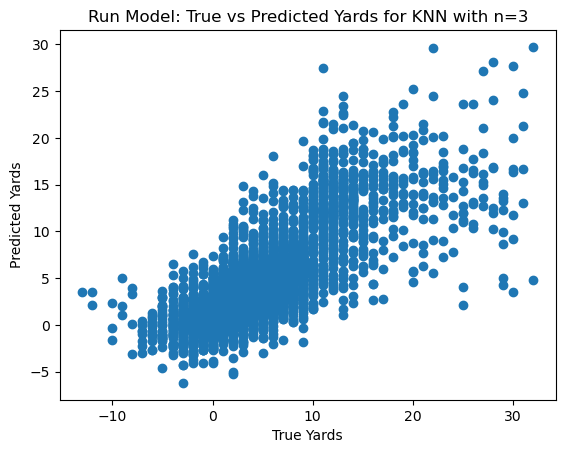

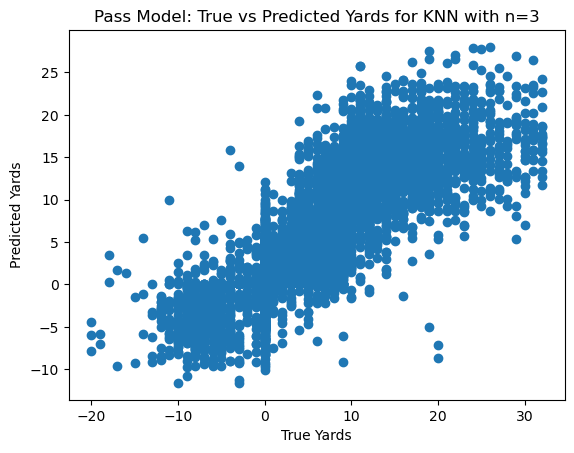

Run Model Mean Squared Error: 9.418775007466417
Pass Model Mean Squared Error: 16.24928097946871


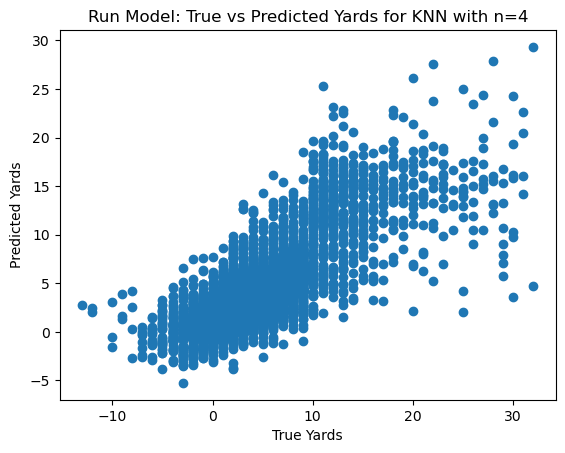

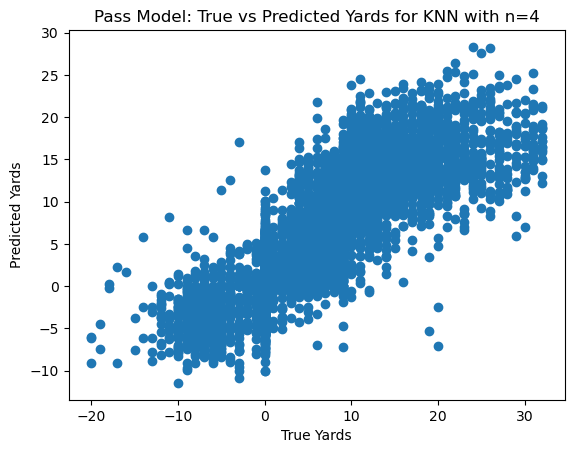

Run Model Mean Squared Error: 9.162214059938512
Pass Model Mean Squared Error: 15.783502335838785


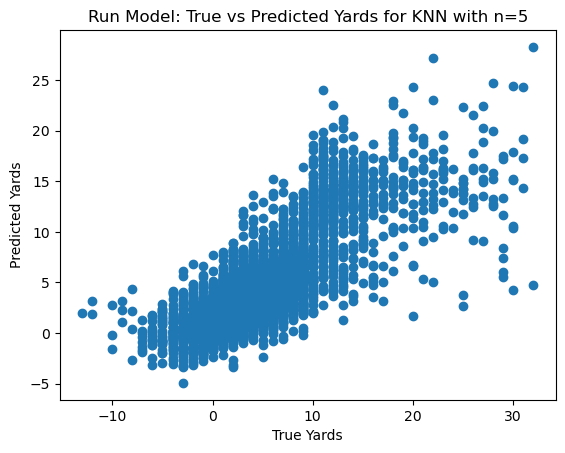

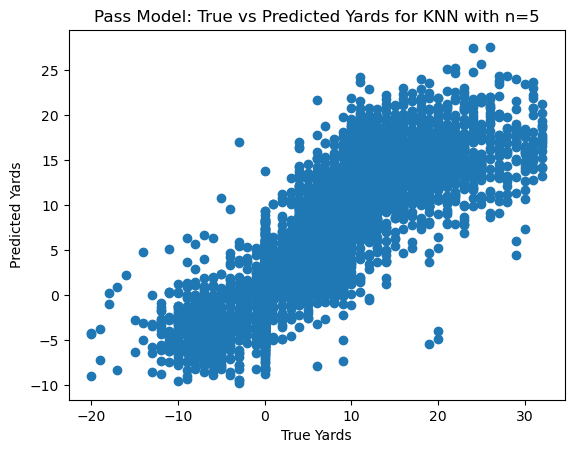

Run Model Mean Squared Error: 9.017585390683037
Pass Model Mean Squared Error: 15.487050837853799


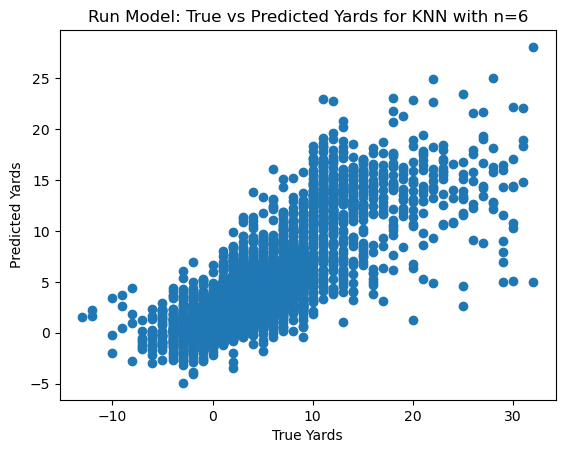

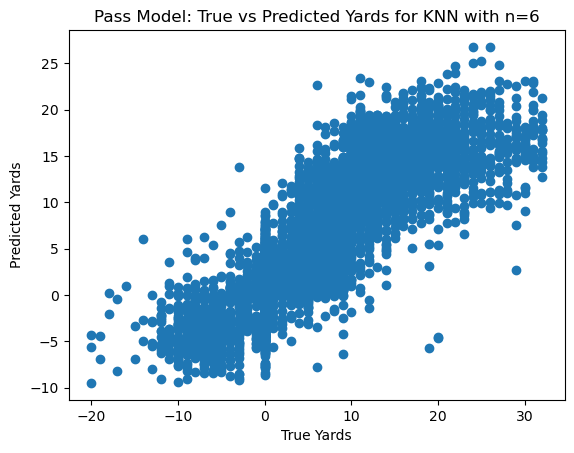

Run Model Mean Squared Error: 8.925080335943266
Pass Model Mean Squared Error: 15.22857443560883


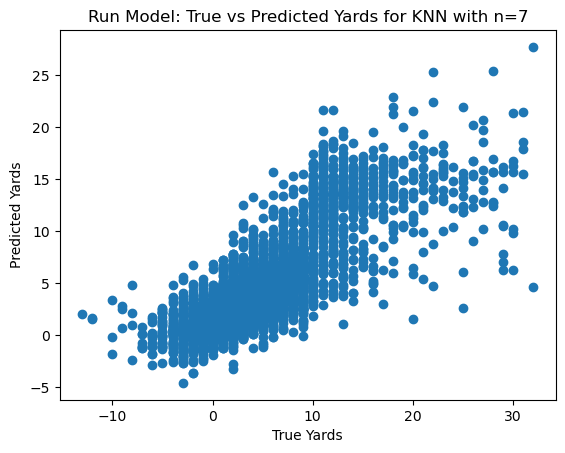

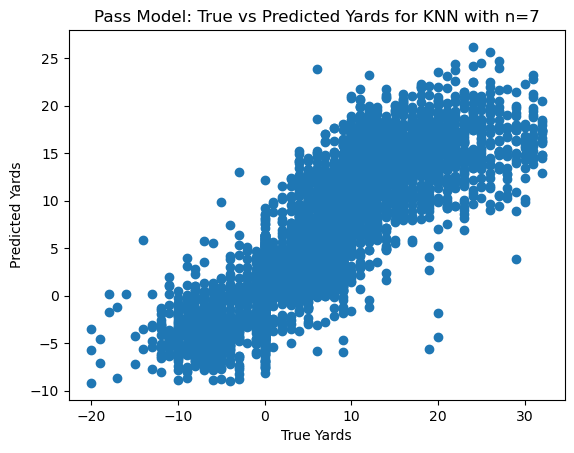

Run Model Mean Squared Error: 8.872613656346656
Pass Model Mean Squared Error: 15.19314864257232


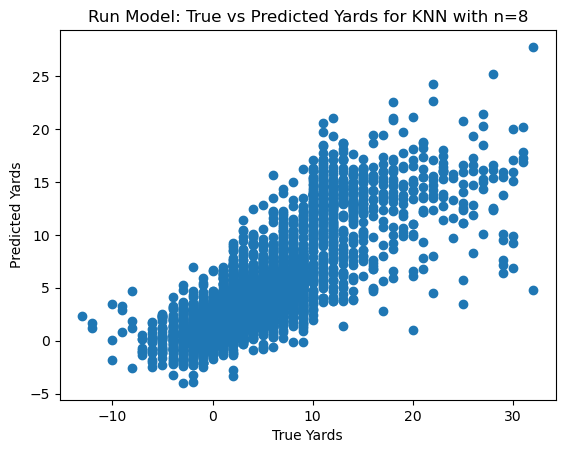

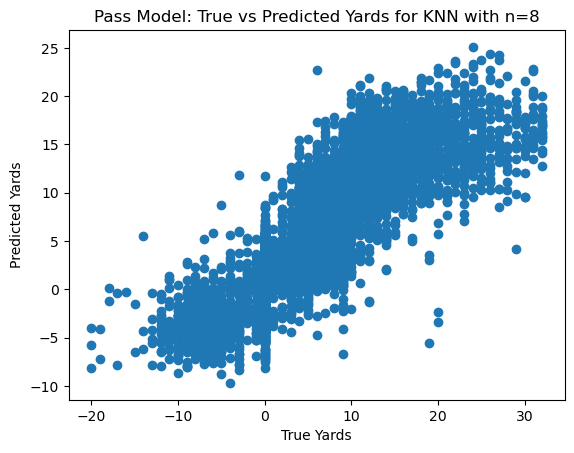

Run Model Mean Squared Error: 8.83291795833505
Pass Model Mean Squared Error: 15.076601990416183


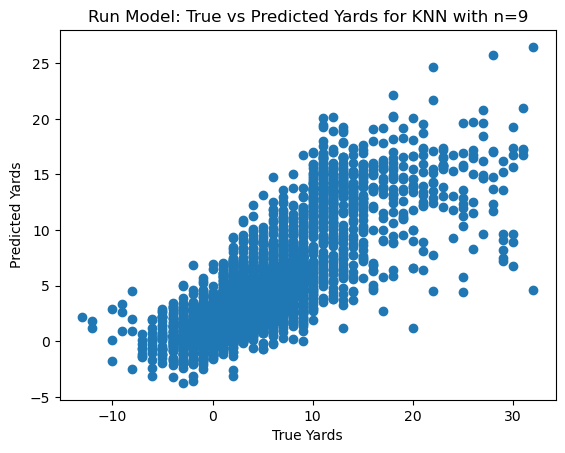

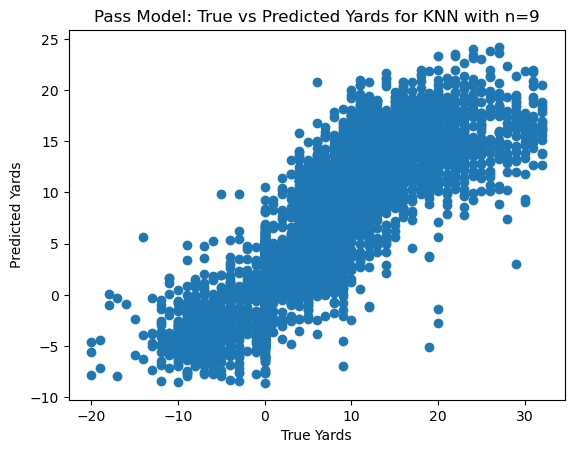

Run Model Mean Squared Error: 8.833537963355298
Pass Model Mean Squared Error: 15.020034437369553


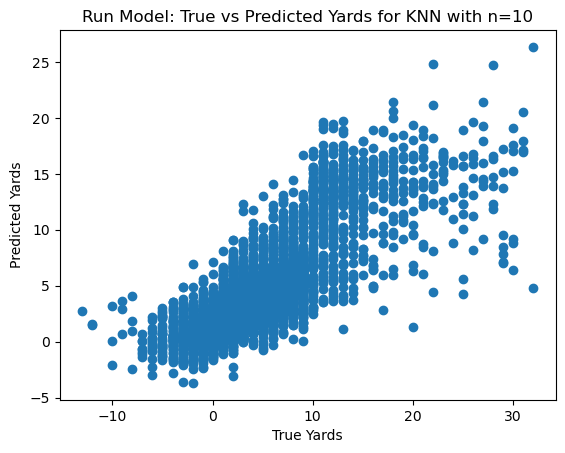

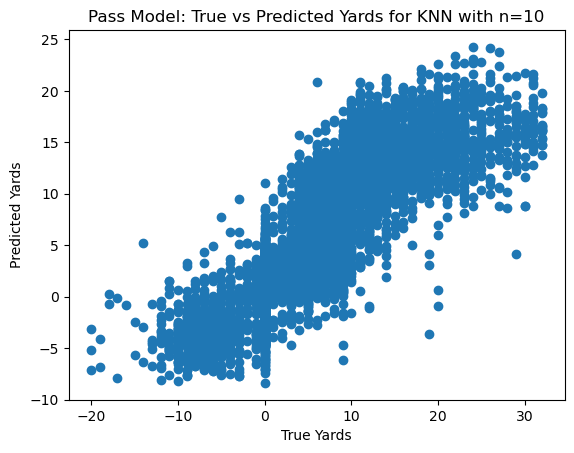

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Standardize the features (important for KNN)
scaler = StandardScaler()
print(pass_X_train)
pass_X_train = scaler.fit_transform(pass_X_train)
print(pass_X_train)
pass_X_test = scaler.transform(pass_X_test)
run_X_train = scaler.fit_transform(run_X_train)
run_X_test = scaler.transform(run_X_test)

for n_neighbors in [3, 4, 5, 6, 7, 8, 9, 10]:

    # Initialize the KNN regressor
    pass_knn_regressor = KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance')
    run_knn_regressor = KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance')

    # Train the model
    pass_knn_regressor.fit(pass_X_train, pass_y_train)
    run_knn_regressor.fit(run_X_train, run_y_train)

    # Make predictions on the test set
    pass_predictions = pass_knn_regressor.predict(pass_X_test)
    run_predictions = run_knn_regressor.predict(run_X_test)

    # Evaluate the model
    run_mse = mean_squared_error(run_y_test, run_predictions)
    pass_mse = mean_squared_error(pass_y_test, pass_predictions)

    print(f"Run Model Mean Squared Error: {run_mse}")
    print(f"Pass Model Mean Squared Error: {pass_mse}")

    # Visualize predictions for runs
    plt.scatter(run_y_test, run_predictions)
    plt.title('Run Model: True vs Predicted Yards for KNN with n=' + str(n_neighbors) )
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

    # Visualize predictions for passes
    plt.scatter(pass_y_test, pass_predictions)
    plt.title('Pass Model: True vs Predicted Yards for KNN with n=' + str(n_neighbors))
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

Random Forest

Run Model Mean Squared Error: 6.5626633212231305
Pass Model Mean Squared Error: 9.995116148923795


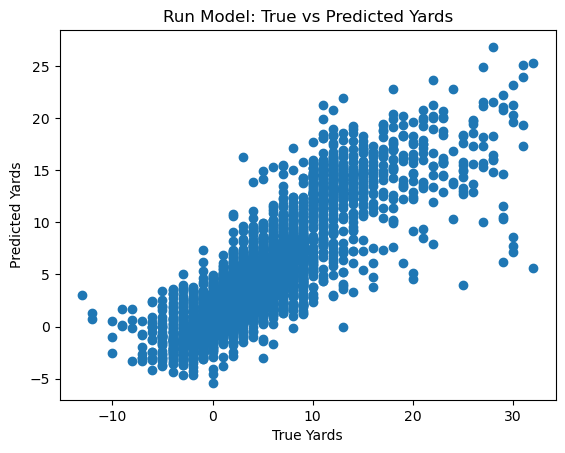

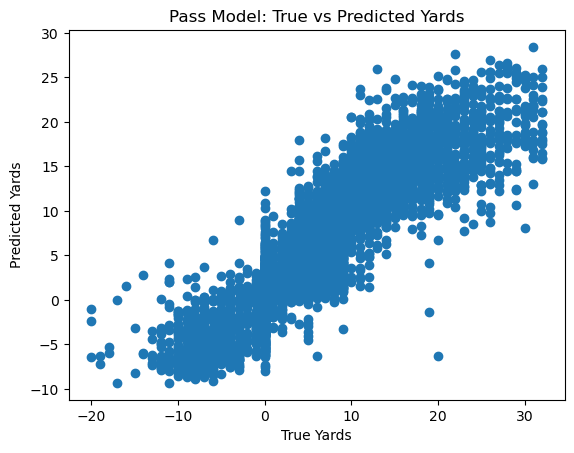

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest regressor
pass_knn_regressor = RandomForestRegressor(n_estimators=100, random_state=42) 
run_knn_regressor = RandomForestRegressor(n_estimators=100, random_state=42) 

# Train the model
pass_knn_regressor.fit(pass_X_train, pass_y_train)
run_knn_regressor.fit(run_X_train, run_y_train)

# Make predictions on the test set
pass_predictions = pass_knn_regressor.predict(pass_X_test)
run_predictions = run_knn_regressor.predict(run_X_test)

# Evaluate the model
run_mse = mean_squared_error(run_y_test, run_predictions)
pass_mse = mean_squared_error(pass_y_test, pass_predictions)

print(f"Run Model Mean Squared Error: {run_mse}")
print(f"Pass Model Mean Squared Error: {pass_mse}")

# Visualize predictions for runs
plt.scatter(run_y_test, run_predictions)
plt.title('Run Model: True vs Predicted Yards')
plt.xlabel('True Yards')
plt.ylabel('Predicted Yards')
plt.show()

# Visualize predictions for passes
plt.scatter(pass_y_test, pass_predictions)
plt.title('Pass Model: True vs Predicted Yards')
plt.xlabel('True Yards')
plt.ylabel('Predicted Yards')
plt.show()